关于CNN先从眼球神经元开始构建一种感性的认知。眼球的一个神经元负责一块区域，多个神经元负责的区域可以有重叠，全部的神经元在一起负责的区域是全部的图。比如有些神经元对横线响应，有些对竖线，而有些是对斜线。这和CNN模型有些不同，CNN模型里的感受野是相同大小的框框，简洁很多，也更容易实现。然后通过堆叠更多的神经元，便可达到同样的效果。

CNN中的图像输入不用展平。就是保持2D，加上通道即可。

feature map: 一个网络层使用一个卷积核能够输出一个特征图。

特征图的特征很像卷积核的特征。这也是为什么称之为特征图的原因。

在训练过程中，CNN逐渐发现最能提取特征的卷积核，因为卷积核的表征方式就是权重矩阵。

网络能够组合多个特征图形成更复杂的模式识别功能。

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### 堆叠特征图

一个卷积核可以生成一个特征图，之前我理解为一个二维的卷积核逐个图层的卷积，真是被维度限制了想象力。

简单说就是，一个神经元的感受野不是一层，而是贯穿的，穿透前面的所有层。我们知道输入层图像是三通道，那么第一个卷积层就是贯穿3层，而一个卷积层有多少个卷积核，该层就有多少层卷积图，下一个卷积层的神经元就贯穿这些层。

很好理解对吧~~

需要打破的认知局限是，我总是觉得一个神经元存储的是一个标量，其实可以存储更复杂的信息。

在书上画出的这个解释，我的理解是，一个卷积核，从图片左上方开始进行卷积计算时，扫一遍即可，不用每个图层都扫一遍，而是同时进行。但是对于卷积计算的结果，我觉得应该是个标量，因为一个特征图是可以类比到一个图片的图层的。

读懂书上的这个图，就能够很清晰地理解了网络参数为啥这样构建了。

数学公式没看懂的啊。

#### 直观的理解

看了代码的写法，应该这么来理解卷积核，就是当前层的输入的一小块。shape是：height,width,channels，这样设计才好与输入进行点积计算。

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_sample_images

In [4]:
dataset = np.array(load_sample_images().images, dtype=np.float32)
batch_size, height, width, channels = dataset.shape

/Applications/anaconda/lib/python3.6/site-packages/sklearn/datasets/base.py:692: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Applications/anaconda/lib/python3.6/site-packages/sklearn/datasets/base.py:692: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


In [5]:
dataset.shape # 个数，height, width, channels

(2, 427, 640, 3)

In [6]:
filters_test = np.zeros(shape=(7,7,channels,2),dtype=np.float32)
filters_test[:,3,:0] = 1 # 竖线
filters_test[3,:,:1] = 1 # 横线

In [7]:
filters_test[:,:,:,0]

array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  

In [9]:
# 创建图
X = tf.placeholder(tf.float32,shape=(None,height,width,channels)) # None表示填充多少图片待定
conv = tf.nn.conv2d(X,filters_test,strides=[1,2,2,1],padding='SAME')

with tf.Session() as sess:
    output = sess.run(conv, feed_dict={X:dataset})

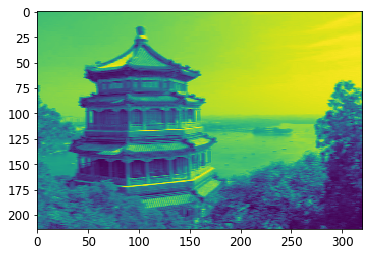

In [10]:
# 不加这行是不显示图片的
%matplotlib inline 
import matplotlib.pyplot as plt
plt.imshow(output[0,:,:,1])

plt.show() # 可以不加这个

### 内存需求

专门写过一篇笔记关于如何计算CNN参数的，这里再复习一下。
假设卷积核是5x5大小，共有200个卷积图，尺寸大小是是150x100，stride=1,用`SAME`类型的填充。补充一下，一般strides参数是个1D的数组，比如:

`strides=[1,2,2,1]`，中间两个用于控制左右和上下的跨越步数，两头的两个一般都设定为1，具体含义是：第一个是用于控制`batch_stride`, 第四个用于控制`channel_stride`.

输入是150x100的RGB图片，那么参数个数计算就是：

$(5 * 5 * 3 + 1) * 200 = 15200.$

用现在理解到的知识来解释就是，一个卷积核是三维的，height,width,channels，再加上多少个的话就可用4D张量来表示了。卷积核是针对图片的，图片也要用三维的眼光来对待，height,width,channels也可再加上channels，也是4D张量。这才是为什么代码里很简洁的用4D张量来表示卷积核与图片的原因。

看上面计算出来的参数总量，远远小于全连接层。

另外，有一种直觉需要打破，RGB图片是三维，但是这个3不是特殊的，只不过是channels这个参数的具体值而已。也就是说任意层的输入都可以用`[height,width,channels,num]`来概括。

再看有多少神经元，因为输出的是特征图，一个层可以输出多个特征图，作为下一层的输入。这里输出是150x100大小，意味着一个特征图对应150x100个神经元。 每个神经元需要计算加权和，对应5x5x3 = 75个输入。一个神经元的值是通过与75个输入连接，对应75个权重值，那么这里就有$75 * 150 * 100 * 200 = 2.25亿$次浮点数乘法。仍然需要大量的计算。

200个特征图，$150 * 100$大小，假设一个浮点数是32bit，那么一层的输出就需要：

$200 * 150 * 100 * 32 = 0.96亿$bits, 11.4MB的内存。这还只是一个实例，如果是100个实例，就将超过1GB内存了。且只是一层。

在考虑推断和训练过程。

推断的话，当前层的内存占用可以在下一层开始计算时就释放，所以需要的内存只要两个连续层占用那么大即可，而在训练过程中，就大不相同了。前向计算的中间结果都必须被保存，以便用于反向传播计算，所以所有层的输出都得保存。这样内存就需要很大。

解决方案可以有：

- 减小mini-batch
- 扩大stride
- 移除部分层
- 使用16位浮点数
- 分布式CNN，多台机器


### Pooling层

一旦理解了卷积操作，Pooling就很简单了。

目标是：下采样输入数据，降低计算量，内存占用以及参数量。因此可以降低过拟合，因为模型的复杂度在降低。

此外，降低输入数据的尺寸，有利于网络结构更健壮。

类似卷积，但是没有权重，而是用`max`或者`mean`函数。

一般Pooling不改变输入数据的通道数。但是可以选择这么做。

In [14]:
batch_size, height, width, channels = dataset.shape

fitlers = np.zeros(shape=(7,7,channels,2),dtype=np.float32) # 等同于filters = np.zeros([7,7,channels,2],dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

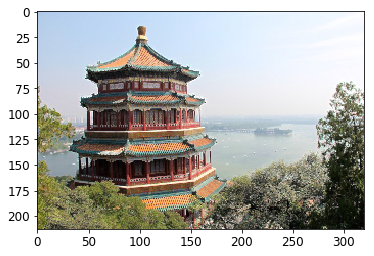

In [21]:
X = tf.placeholder(tf.float32,shape=(None,height,width,channels))
max_pool = tf.nn.max_pool(X,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
plt.imshow(output[0].astype(np.uint8)) # 输出第一幅图
plt.show() 

注意到`max_pool`函数这里有个参数是`ksize`,具体内容与卷积核一样，[batch size, height, width, channels]。

但是需要注意一个问题是，TF还不支持在多个实例上同时进行池化操作，所以第一个值必须为1，也不支持同时在高度x宽度和深度上进行池化，即，要么height,width同时为1，此时channels不必为1，要么channels为1，height，width不必为1这样。

调用方法：

- `tf.nn.max_pool(对象,ksize=[1,x,x,1]),strides=[1,2,2,1],padding='SAME)`
- `tf.nn.avg_pool(对象,ksize=[1,x,x,1]),strides=[1,2,2,1],padding='SAME)`

#### 小总结

到此为止，关于CNN网络的所有构建模块已经讲完了，接下来就是应用，组合了。

传统的CNN架构都是堆叠一些卷积层 + ReLU层 + Pooling层。通过这种堆叠操作，数据的height，width越来越小，但是channels越来越多，也就是说卷积核个数越来越多。

在栈顶一般是全连接层，因为前面的特征提取完成之后，最后一层像是筛子一样，仔细筛选提取出来的精华，全连接层会加一个ReLU层。最后的最后是一个预测层，用Softmax层，输出估计的类别的概率。

关于卷积核的大小设计，有个常见的错误是，选择的卷积核过大，比如9x9.实际上大的卷积核是可以通过堆叠多个小的卷积核来实现相同效果的，比如3x3，这样可以减少计算量。

ImageNet的Top-5错误率是给出5个估计都没包含正确答案。

在理解了基础的CNN知识后，通过跟踪阅读ImageNet每年比赛的冠军模型，能够帮助我们理解CNN是怎么工作的，下面的篇幅就是要介绍一些很厉害的CNN模型。

- 经典LeNet-5架构
- AlexNet(2012)
- GoogleLeNet(2014)
- ResNet(2015)

NameError: name 'plot_color_image' is not defined

### 关于TF的一些最新变化

Note: instead of using the `fully_connected()`, `conv2d()` and `dropout()` functions from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()`, `conv2d()` and `dropout()` functions (respectively) from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

For all these functions:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).

The other main differences in `tf.layers.dense()` are:
* the `weights` parameter was renamed to `kernel` (and the weights variable is now named `"kernel"` rather than `"weights"`),
* the default activation is `None` instead of `tf.nn.relu`

The other main differences in `tf.layers.conv2d()` are:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the default `activation` is now `None` instead of `tf.nn.relu`.

The other main differences in `tf.layers.dropout()` are:
* it takes the dropout rate (`rate`) rather than the keep probability (`keep_prob`). Of course, `rate == 1 - keep_prob`,
* the `is_training` parameters was renamed to `training`.

### LeNet-5

架构一览：

- 输入层： 32 x 32 
- 卷积层, 输出：28x28, 6个卷积核，5x5卷积核大小，tanh激活函数
- 均值池化, 输出：14x14，2x2大小, tanh激活函数
- 卷积层， 输出：10x10, 16个卷积核，5x5卷积核大小，tanh激活函数
- 均值池化，输出：5x5, 2x2大小，tanh激活函数
- 卷积层，输出：1x1，120个卷积核，5x5卷积核大小，tanh激活函数 -- 意味着展平后有120个神经元
- 全连接层，84个神经元，tanh激活函数
- 全连接层，10个神经元，RBF激活函数

关于MNIST的一些细节：

- 本身是28x28像素的图片，但是用了0-填充，变成32x32的图像，并做了归一化处理。
- LeNet的均值池化计算比较复杂，不是简单的取平均。
- 第二个卷积层的神经元只是部分与前一层的特征图相连接。
- 输出层也比较特殊，不是计算输入与权重向量的点积，而是输出输入向量与权重向量的欧式距离

### 网络细节

#### AlexNet

top-5 17%

#### GoogleLeNet

top-5 小于7%

Inception模块，使得GoogleLeNet能够更高效地利用参数：比AlexNet少10倍参数。不用觉得Inception难以理解，之前觉得难以理解的原因是不是特别理解卷积计算，所以会恐慌。

一个非常清楚的解释是这个：在Inception Module中，无论是卷积层还是最大池化层，用的都是`SAME`的padding方式，使得输出的结果都是相同的height,width的特征图，然后在Depth Concat层，把这些特征图堆叠起来就好了。使用TF的做法就是：`concat`函数，以及`axis=3`，沿着deth轴进行连接。原来真的好好理解。

1x1卷积核的目的是为了降维。

这种不同大小的卷积核的组合，能够捕捉更加复杂的模式，且是在不同的尺度上。

GoogleLeNet包含9个Inception模块。

#### ResNet

top-5 约为3.6%

152层，关键点在于`skip connections`，也称作`shortcut connections`。

用更简洁的说法是：喂给该层的的数据也会被加和到该层之上的其他层的输出。可以是高一层也可以是高更多。

残差的思想都是去掉相同的主体部分，从而突出微小的变化。

普通的神经网络目的是去对目标函数`h(x)`建模,如果把输入`x`也加入到网络的输出，模型就会变成去对`f(x) = h(x) - x`进行建模。这就被称之为残差学习。

### Tensorflow卷积操作实现细节

TF也提供了几种不同的卷积层定义：

- `conv1d`: 针对1D输入进行卷积操作，这在NLP中很有用
- `atrous_conv2d`: 带洞的卷积操作
- `conv3d`: 针对3D输入进行卷积操作，比如3D扫描仪
- `conv2d_transpose`: 也被称作**deconvolutional层**。上采样一个图，因为卷积会配合其他的操作使得图片越来越小，这个反卷积需要填充0，使得输出与原始输入大小一致
- `depthwise_conv2d`
- `separable_conv2d`

### 练习

1.CNN相对

In [31]:
# 这是练习题第7题

height,width,channels = 28,28,1
n_inputs = height * width # 计算输入层神经元个数

# 注意这个网络不是LeNet-5

conv1_fmaps = 32 # 卷积核个数，也是特征图个数，二者等价
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = 'SAME'

pool3_fmaps = conv2_fmaps

n_fc1 = 64 # 全连接层神经元个数
n_outputs = 10

reset_graph() # 重置图

# 用name_scope组织代码
with tf.name_scope('inputs'):
    X = tf.placeholder(dtype=tf.float32, shape=[None,n_inputs],name='X')
    X_reshaped = tf.reshape(X, shape=[-1,height,width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name='y')

conv1 = tf.layers.conv2d(X_reshaped,filters=conv1_fmaps,kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,activation=tf.nn.relu,name='conv1')
conv2 = tf.layers.conv2d(conv1,filters=conv2_fmaps,kernel_size=conv2_ksize,
                        strides=conv2_stride,padding=conv2_pad,activation=tf.nn.relu,name='conv2')

with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    pool3_flat = tf.reshape(pool3,shape=[-1,pool3_fmaps * 7 * 7])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(pool3_flat,n_fc1, activation=tf.nn.relu, name='fc1')

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1,n_outputs, name='output')
    Y_proba = tf.nn.softmax(logits,name='Y_proba')

# 训练
with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss) # 优化
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

with tf.name_scope('init'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [32]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [33]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.99 Test accuracy: 0.9779
1 Train accuracy: 0.96 Test accuracy: 0.981
2 Train accuracy: 0.99 Test accuracy: 0.9871
3 Train accuracy: 0.99 Test accuracy: 0.9878
4 Train accuracy: 1.0 Test accuracy: 0.9891
5 Train accuracy: 0.99 Test accuracy: 0.9914
6 Train accuracy: 1.0 Test accuracy: 0.9895
7 Train accuracy: 1.0 Test accuracy: 0.989
8 Train accuracy: 0.99 Test accuracy: 0.9884
9 Train accuracy: 1.0 Test accuracy: 0.9884
